# 1. Initializations and Dataset Download with google colab

In [ ]:
!pip install transformers --quiet
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cookiett
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mv news-headlines-dataset-for-sarcasm-detection /content/drive/MyDrive/Data

**Using google colab**

```
drive/MyDrive/Data/news-headlines-dataset-for-sarcasm-detection/
├── Sarcasm_Headlines_Dataset.json (26709 news)
{
  {
    "article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5",
    "headline": "former versace store clerk sues over secret 'black code' for minority shoppers",
    "is_sarcastic": 0
  },
  {
    "article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365",
    "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
    "is_sarcastic": 0
  }
  ,...
}
|
└── Sarcasm_Headlines_Dataset_v2.json/ (28619 news)
{
  {
    "article_link": "https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5",
    "headline": "former versace store clerk sues over secret 'black code' for minority shoppers",
    "is_sarcastic": 0
  },
  {
    "article_link": "https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365",
    "headline": "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
    "is_sarcastic": 0
  }
  ,...
}
```

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_scheduler
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


# 2. Dataset

In [47]:
data_dir = '/content/drive/MyDrive/Data/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json'
data_df = pd.read_json(data_dir, lines=True)
data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
print("Data shape is: ", data_df.shape)
data_df.head()

Data shape is:  (26708, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


**Remove 'article_link' column'**

뉴스에 대한 디테일한 내용은 필요없기 때문에 링크 자체는 학습시킬 필요가 없다.

In [48]:
data_df.drop(['article_link'], inplace=True, axis=1)
print("Data shape is: ", data_df.shape)
data_df.head()

Data shape is:  (26708, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


# 3. Data Spliting

- Clean train/val/test split with stratification (70/15/15)

In [49]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df["headline"]), np.array(data_df["is_sarcastic"]), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print("Training set is: ", X_train.shape[0], " rows which is ", round(X_train.shape[0]/data_df.shape[0],4)*100, "%")
print("Validation set is: ",X_val.shape[0], " rows which is ", round(X_val.shape[0]/data_df.shape[0],4)*100, "%")
print("Testing set is: ",X_test.shape[0], " rows which is ", round(X_test.shape[0]/data_df.shape[0],4)*100, "%")

Training set is:  18695  rows which is  70.0 %
Validation set is:  4006  rows which is  15.0 %
Testing set is:  4007  rows which is  15.0 %


# 4. Initialize tokenizer and model

- Using RoBERTa model instead of BERT for better performance

In [51]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

 roberta-base model has three `problem_type` options: `single_label_classification`, `multi_label_classification`, and `regression`.

 - `num_labels`: This argument determines the number of output classes your model will predict. Since you have 2 labels (negative, positive), you need to set `num_labels=2`. By doing this, the model will have two output neurons, one for each class.
 - `problem_type`: You are using "single_label_classification" which is correct because each headline should belong to only one sentiment category (0 or 1).
   - `multi_label_classification`: This option is used when a single input can belong to multiple classes. For example, if you were classifying news headlines into multiple categories (e.g., politics, sports, entertainment), you would use this option.
   - `regression`: This option is used when you want to predict a continuous value. For example, if you were predicting the price of a house, you would use this option.

In [52]:
# Load model with specified number of labels
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 5. Dataset & Transforms

In [53]:
class SarcasmDataset(Dataset):
    """Modern dataset implementation for text classification"""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Use batch_encode_plus for more efficient tokenization
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors=None  # Return as python lists instead of tensors
        )

        # Convert to tensors here
        item = {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

        return item

In [54]:
# Prepare datasets
train_dataset = SarcasmDataset(X_train, y_train, tokenizer)
val_dataset = SarcasmDataset(X_val, y_val, tokenizer)
test_dataset = SarcasmDataset(X_test, y_test, tokenizer)

# 6. Create dataloaders

In [55]:
# Create dataloaders
batch_size = 16  # Smaller batch size for better generalization

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size
)

# 7. Move model to device

In [56]:
model = model.to(device)

# 8. Fine-tuning setup

In [57]:
# Unfreeze only the last few layers of the transformer
# This is a compromise between feature extraction and full fine-tuning
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze the last 2 transformer layers
for layer in model.base_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# 9. Setup optimizer with weight decay

In [58]:
# AdamW includes weight decay for regularization
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-5,  # Lower learning rate for fine-tuning
    weight_decay=0.01  # Add weight decay for regularization
)

# 10. Learning rate scheduler with warmup

In [59]:
# Unfreeze the classifier layer
for param in model.classifier.parameters():
    param.requires_grad = True

num_epochs = 5  # Fewer epochs with better training regime
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
    name="linear",  # Linear scheduler with warmup
    optimizer=optimizer,
    num_warmup_steps=0.1 * num_training_steps,  # 10% warmup
    num_training_steps=num_training_steps
)

# 11. Training loop

In [60]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch (multi-class version)"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Show progress bar during training
    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 1. Do the Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # 2. Calculate the loss
        loss = F.cross_entropy(logits, labels.view(-1))

        # 3. Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() # Update weights
        scheduler.step() # Update learning rate

        # Prediction and accuracy
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_loss += loss.item()
        total_predictions += labels.size(0)

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item(),
                                 'accuracy': correct_predictions / total_predictions})

    # Calculate final metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions

    return avg_loss, accuracy

In [61]:
def evaluate(model, dataloader, device):
    """Evaluate the model (multi-class version)"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.inference_mode():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 1. Do the Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            # 2. Calculate the loss
            loss = F.cross_entropy(logits, labels.view(-1))
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=-1)
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    all_predictions = np.array(all_predictions).flatten()
    all_labels = np.array(all_labels).flatten()
    accuracy = accuracy_score(all_labels, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_predictions, average='binary', pos_label=1
    )
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

You're using `average='binary'` which is suitable for binary classification (two classes). However, your task is a multi-class classification problem with three sentiment labels (negative, neutral, positive). This is why you're getting the ValueError: Target is multiclass but average='binary'.

Solution:

Change average='binary' to one of the options suitable for multi-class classification: 'micro', 'macro', or 'weighted'.

'micro': Calculates metrics globally by counting the total true positives, false negatives, and false positives.
'macro': Calculates metrics for each label and finds their unweighted mean. This does not take label imbalance into account.
'weighted': Calculates metrics for each label and finds their average weighted by support (the number of true instances for each label). This accounts for label imbalance.

In [62]:
print(f"Starting training for {num_epochs} epochs...")

# Initialize metrics tracking
train_metrics = {'loss': [], 'accuracy': []}
val_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train for one epoch
    train_loss, train_acc = train_epoch(
        model, train_dataloader, optimizer, lr_scheduler, device
    )

    # Evaluate on validation set
    val_results = evaluate(model, val_dataloader, device)

    # Store metrics
    train_metrics['loss'].append(train_loss)
    train_metrics['accuracy'].append(train_acc)

    val_metrics['loss'].append(val_results['loss'])
    val_metrics['accuracy'].append(val_results['accuracy'])
    val_metrics['precision'].append(val_results['precision'])
    val_metrics['recall'].append(val_results['recall'])
    val_metrics['f1'].append(val_results['f1'])

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_results['loss']:.4f}, Val Accuracy: {val_results['accuracy']:.4f}")
    print(f"Val Precision: {val_results['precision']:.4f}, Val Recall: {val_results['recall']:.4f}, Val F1: {val_results['f1']:.4f}")
    print("="*50)

Starting training for 5 epochs...
Epoch 1/5


Training:   0%|          | 0/1169 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.4228, Train Accuracy: 0.7829
Val Loss: 0.3613, Val Accuracy: 0.8697
Val Precision: 0.9524, Val Recall: 0.7365, Val F1: 0.8306
Epoch 2/5


Training:   0%|          | 0/1169 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.2398, Train Accuracy: 0.9021
Val Loss: 0.2663, Val Accuracy: 0.8969
Val Precision: 0.9379, Val Recall: 0.8165, Val F1: 0.8730
Epoch 3/5


Training:   0%|          | 0/1169 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.2008, Train Accuracy: 0.9204
Val Loss: 0.2431, Val Accuracy: 0.9094
Val Precision: 0.9273, Val Recall: 0.8585, Val F1: 0.8915
Epoch 4/5


Training:   0%|          | 0/1169 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.1801, Train Accuracy: 0.9325
Val Loss: 0.2429, Val Accuracy: 0.9156
Val Precision: 0.9279, Val Recall: 0.8734, Val F1: 0.8998
Epoch 5/5


Training:   0%|          | 0/1169 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/251 [00:00<?, ?it/s]

Train Loss: 0.1602, Train Accuracy: 0.9411
Val Loss: 0.2442, Val Accuracy: 0.9154
Val Precision: 0.9284, Val Recall: 0.8723, Val F1: 0.8994


# 12. Plot metrics

In [63]:
def plot_metrics(train_metrics, val_metrics):
    """Plot training and validation metrics"""
    epochs = range(1, len(train_metrics['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_metrics['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, val_metrics['loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_metrics['accuracy'], 'b-', label='Training Accuracy')
    plt.plot(epochs, val_metrics['accuracy'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

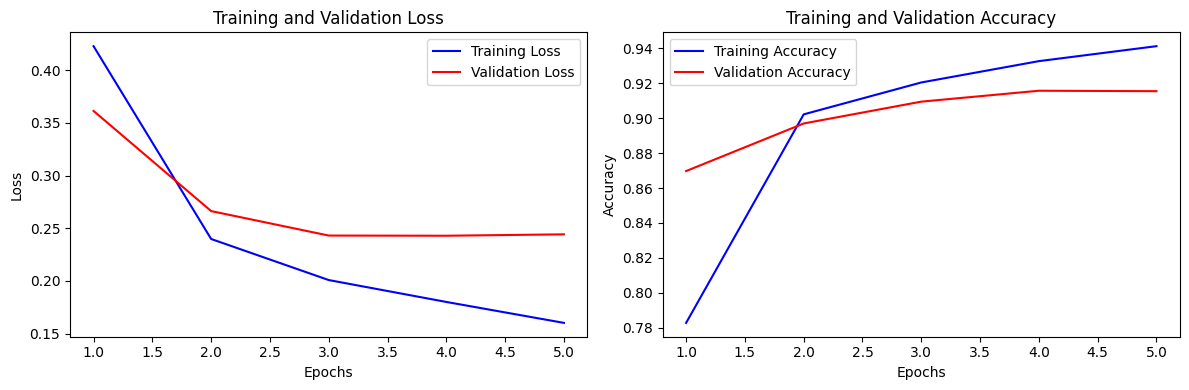

In [64]:
plot_metrics(train_metrics, val_metrics)

# 13. Evaluate on test set

In [65]:
print("Evaluating on test set...")
test_results = evaluate(model, test_dataloader, device)
print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall: {test_results['recall']:.4f}")
print(f"Test F1: {test_results['f1']:.4f}")

Evaluating on test set...


Evaluating:   0%|          | 0/251 [00:00<?, ?it/s]

Test Accuracy: 0.9194
Test Precision: 0.9301
Test Recall: 0.8788
Test F1: 0.9037


# 14. Save model

In [66]:
model_save_path = "roberta_sarcasm_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to roberta_sarcasm_model


In [67]:
!mv roberta_sarcasm_model /content/drive/MyDrive/Data

# 15. Load and Inference model

In [ ]:
# 구글 드라이브에 미리 올린 압축파일을 풀기 위해 라이브러리를 불러오기
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Data/roberta_sarcasm_model.zip', 'r') # 압축 파일(zip file) 읽기
zip_ref.extractall('/content/drive/MyDrive/Data/') # 압출 파일을 풀어서 지정한 폴더(예: Data 폴더)에 저장
zip_ref.close()

In [68]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_dir = "/content/drive/MyDrive/Data/roberta_sarcasm_model"

def inference(text, model_dir=model_dir):
    """Load model and tokenizer from disk and predict sarcasm for a single text (multi-class version)."""

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model = model.to(device)
    model.eval()

    # Tokenize input
    encoding = tokenizer(
        text,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.inference_mode():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()
        sarcasm_prob = probs[0,1].item()  # Probability for class 1 (sarcastic)
        print(f"Text: {text}")
        print(f"Sarcasm probability: {sarcasm_prob:.4f}")
        print(f"Prediction: {'Sarcastic' if pred_class == 1 else 'Not Sarcastic'}")
    return pred_class, sarcasm_prob

In [69]:
print("\n--- Inference Example ---")
test_text = "Oh great, another rainy day. Just what I needed!"
inference(test_text)


--- Inference Example ---
Text: Oh great, another rainy day. Just what I needed!
Sarcasm probability: 0.0016
Prediction: Not Sarcastic


(0, 0.0015531368553638458)